<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML2/blob/main/TimeSeries_Multi/Multi_DA-RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K

# Initialisation TPU

In [2]:
import os

use_tpu = True

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TPU_ADDRESS = ''

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.115.100.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.115.100.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


# Chargement et correction des données

**1. Chargement des données**

In [3]:
!rm *.csv
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Seq2Seq/Data/Power_PV.csv"

rm: cannot remove '*.csv': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   177  100   177    0     0    347      0 --:--:-- --:--:-- --:--:--   347
100 1790k  100 1790k    0     0  1826k      0 --:--:-- --:--:-- --:--:-- 6756k


**2. Analyse et correction des données**

In [4]:
# Création de la série sous Pandas
df_data = pd.read_csv("Power_PV.csv")
df_data

,Date,Temp. (°C),Humid. Rel (%),Vent (m/s),Pression (mbar),Ensolleillement (W/m2),watts
0,2018-07-01 00:00:00,18.230667,78.229330,1.434800,930.0,0.0,0.0
1,2018-07-01 00:15:00,18.274668,78.177330,1.141000,930.0,0.0,0.0
2,2018-07-01 00:30:00,18.438667,77.388664,1.375600,930.0,0.0,0.0
3,2018-07-01 00:45:00,18.439333,77.211334,1.177733,930.0,0.0,0.0
4,2018-07-01 01:00:00,18.384000,77.567340,1.409467,930.0,0.0,0.0
...,...,...,...,...,...,...,...
27548,2019-04-13 23:00:00,21.508667,85.333336,2.168933,929.0,0.0,0.0
27549,2019-04-13 23:15:00,21.448000,85.680000,1.835733,929.0,0.0,0.0
27550,2019-04-13 23:30:00,21.527334,85.346664,2.152133,929.0,0.0,0.0
27551,2019-04-13 23:45:00,21.374666,86.200000,1.666067,929.0,0.0,0.0


Affiche les types :

In [5]:
df_data.dtypes

Date                       object
Temp. (°C)                float64
Humid. Rel (%)            float64
Vent (m/s)                float64
Pression (mbar)           float64
Ensolleillement (W/m2)    float64
watts                     float64
dtype: object

Converison des types `object` en `float32` :

In [6]:
df_data.iloc[:,1:] = pd.DataFrame.replace(df_data.iloc[:,1:],"?","NaN")
df_data.iloc[:,1:] = df_data.iloc[:,1:].astype(np.float32)
df_data

,Date,Temp. (°C),Humid. Rel (%),Vent (m/s),Pression (mbar),Ensolleillement (W/m2),watts
0,2018-07-01 00:00:00,18.230667,78.229332,1.434800,930.0,0.0,0.0
1,2018-07-01 00:15:00,18.274668,78.177330,1.141000,930.0,0.0,0.0
2,2018-07-01 00:30:00,18.438667,77.388664,1.375600,930.0,0.0,0.0
3,2018-07-01 00:45:00,18.439333,77.211334,1.177733,930.0,0.0,0.0
4,2018-07-01 01:00:00,18.384001,77.567337,1.409467,930.0,0.0,0.0
...,...,...,...,...,...,...,...
27548,2019-04-13 23:00:00,21.508667,85.333336,2.168933,929.0,0.0,0.0
27549,2019-04-13 23:15:00,21.448000,85.680000,1.835733,929.0,0.0,0.0
27550,2019-04-13 23:30:00,21.527334,85.346664,2.152133,929.0,0.0,0.0
27551,2019-04-13 23:45:00,21.374666,86.199997,1.666067,929.0,0.0,0.0


In [7]:
df_data.dtypes

Date                       object
Temp. (°C)                float32
Humid. Rel (%)            float32
Vent (m/s)                float32
Pression (mbar)           float32
Ensolleillement (W/m2)    float32
watts                     float32
dtype: object

In [8]:
# Définition des dates de début et de fin

date_debut = "2018-07-01 00:00:00"
date_fin = "2019-04-14 00:00:00"

# Place l'index du dataframe sur la colonne Date
df_data = df_data.rename(columns={'Unnamed: 0': "Date"})
df_data = df_data.set_index(df_data['Date'])

# Copie des données dans le dataframe d'étude sur l'intervalle d'étude
df_etude = df_data.loc[date_debut:date_fin].copy()

# Conversion de la colonne Date au format datetime
df_etude.index = pd.to_datetime(df_etude.index)

# Suppression de la colonne Unnamed:0
df_etude = df_etude.drop("Date", axis=1)
df_etude

,Temp. (°C),Humid. Rel (%),Vent (m/s),Pression (mbar),Ensolleillement (W/m2),watts
Date,,,,,,
2018-07-01 00:00:00,18.230667,78.229332,1.434800,930.0,0.0,0.0
2018-07-01 00:15:00,18.274668,78.177330,1.141000,930.0,0.0,0.0
2018-07-01 00:30:00,18.438667,77.388664,1.375600,930.0,0.0,0.0
2018-07-01 00:45:00,18.439333,77.211334,1.177733,930.0,0.0,0.0
2018-07-01 01:00:00,18.384001,77.567337,1.409467,930.0,0.0,0.0
...,...,...,...,...,...,...
2019-04-13 23:00:00,21.508667,85.333336,2.168933,929.0,0.0,0.0
2019-04-13 23:15:00,21.448000,85.680000,1.835733,929.0,0.0,0.0
2019-04-13 23:30:00,21.527334,85.346664,2.152133,929.0,0.0,0.0


Vérification des données et correction des anomalies :

In [9]:
np.sum(np.isnan(df_etude.iloc[:,1:]))

Humid. Rel (%)            62
Vent (m/s)                62
Pression (mbar)           62
Ensolleillement (W/m2)    62
watts                     62
dtype: int64

In [10]:
df_etude = df_etude.fillna(method="backfill")

In [11]:
np.sum(np.isnan(df_etude.iloc[:,1:]))

Humid. Rel (%)            0
Vent (m/s)                0
Pression (mbar)           0
Ensolleillement (W/m2)    0
watts                     0
dtype: int64

**5. Affiche les données**

In [12]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_etude.index,y=df_etude['watts'], line=dict(color='blue', width=1),name="Puissance (W)"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Sélection des données

On ne garde que les données suivantes :
- Température
- Humidité relative
- Ensoleillement

In [13]:
# Suppression de la colonne Unnamed:0
df_etude = df_etude.drop("Vent (m/s)", axis=1)
df_etude = df_etude.drop("Pression (mbar)", axis=1)

df_etude

,Temp. (°C),Humid. Rel (%),Ensolleillement (W/m2),watts
Date,,,,
2018-07-01 00:00:00,18.230667,78.229332,0.0,0.0
2018-07-01 00:15:00,18.274668,78.177330,0.0,0.0
2018-07-01 00:30:00,18.438667,77.388664,0.0,0.0
2018-07-01 00:45:00,18.439333,77.211334,0.0,0.0
2018-07-01 01:00:00,18.384001,77.567337,0.0,0.0
...,...,...,...,...
2019-04-13 23:00:00,21.508667,85.333336,0.0,0.0
2019-04-13 23:15:00,21.448000,85.680000,0.0,0.0
2019-04-13 23:30:00,21.527334,85.346664,0.0,0.0


# Séparation des données de test et d'entrainement

In [118]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(df_etude.values) * pourcentage)
date_separation = df_etude.index[temps_separation]

serie_entrainement_X = np.array(df_etude.values[:temps_separation],dtype=np.float32)
serie_test_X = np.array(df_etude.values[temps_separation:],dtype=np.float32)

print("Taille de l'entrainement : %d" %len(serie_entrainement_X))
print("Taille de la validation : %d" %len(serie_test_X))

Taille de l'entrainement : 22042
Taille de la validation : 5511


**Normalisation des données :**

On normalise les données à l'aide de la fonction [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [119]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
serie_entrainement_X_norm = []
serie_test_X_norm = []

for i in range(0,len(df_etude.columns)):
  serie_entrainement_X_norm.append(min_max_scaler.fit_transform(tf.reshape(serie_entrainement_X[:,i],shape=(len(serie_entrainement_X[:,i]),1))))
  serie_test_X_norm.append(min_max_scaler.fit_transform(tf.reshape(serie_test_X[:,i],shape=(len(serie_test_X[:,i]),1))))

serie_entrainement_X_norm = tf.convert_to_tensor(serie_entrainement_X_norm)
serie_entrainement_X_norm = tf.squeeze(serie_entrainement_X_norm,-1)
serie_entrainement_X_norm = tf.transpose(serie_entrainement_X_norm)

serie_test_X_norm = tf.convert_to_tensor(serie_test_X_norm)
serie_test_X_norm = tf.squeeze(serie_test_X_norm,-1)
serie_test_X_norm = tf.transpose(serie_test_X_norm)


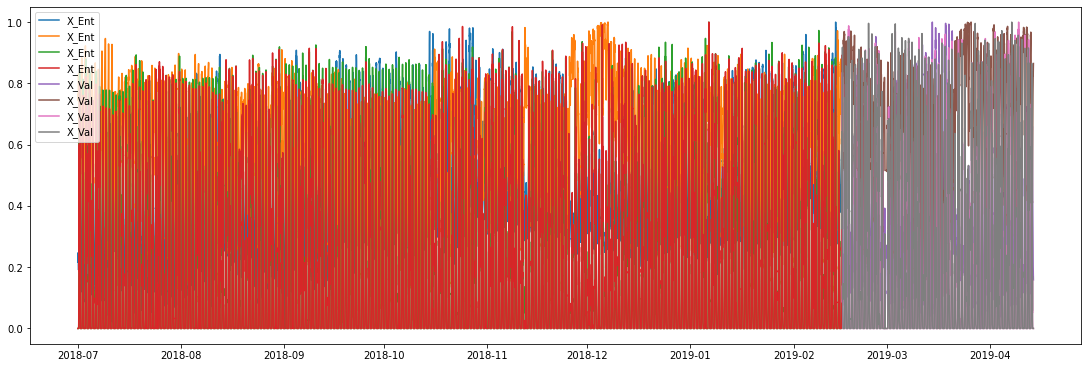

In [120]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(df_etude.index[:temps_separation].values,serie_entrainement_X_norm, label="X_Ent")
ax.plot(df_etude.index[temps_separation:].values,serie_test_X_norm, label="X_Val")

ax.legend()
plt.show()

# Création des datasets

**1. Tests**

In [114]:
X1 = np.linspace(1,100,100)
X2 = np.linspace(101,200,100)
X3 = np.linspace(201,300,100)
Y = np.linspace(301,400,100)

X1 = tf.expand_dims(X1,-1)
X2 = tf.expand_dims(X2,-1)
X3 = tf.expand_dims(X3,-1)
Y = tf.expand_dims(Y,-1)

Serie_X = tf.concat([X1,X2,X3],axis=1)
Serie_Y = Y
print(Serie_X.shape)

# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),((X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT-1)}
# Y = YT

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence-1][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-1:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

test_dataset = prepare_dataset_XY(Serie_X,Serie_Y,10,1,1,1)

print(len(list(test_dataset.as_numpy_iterator())))
for element in test_dataset.take(1):
  print(element)

(100, 3)
90
((<tf.Tensor: shape=(1, 10, 3), dtype=float64, numpy=
array([[[  1., 101., 201.],
        [  2., 102., 202.],
        [  3., 103., 203.],
        [  4., 104., 204.],
        [  5., 105., 205.],
        [  6., 106., 206.],
        [  7., 107., 207.],
        [  8., 108., 208.],
        [  9., 109., 209.],
        [ 10., 110., 210.]]])>, <tf.Tensor: shape=(1, 9, 1), dtype=float64, numpy=
array([[[301.],
        [302.],
        [303.],
        [304.],
        [305.],
        [306.],
        [307.],
        [308.],
        [309.]]])>), <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[310.]]])>)


**2. Préparation des datasets**

In [166]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT-1)}
# Y = YT

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence-1][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-1:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

In [167]:
# Définition des caractéristiques du dataset que l'on souhaite créer
batch_size = 512
longueur_sequence = 10
longueur_sortie = 1
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm[:,0:-1],serie_entrainement_X_norm[:,-1:], longueur_sequence,longueur_sortie,batch_size,shift)
dataset_val = prepare_dataset_XY(serie_test_X_norm[:,0:-1],serie_test_X_norm[:,-1:],longueur_sequence,longueur_sortie,batch_size,shift)

In [168]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # (Y1,Y2,...,YT-1)
  print(element[1].shape)               # YT

43
(512, 10, 3)
(512, 9, 1)
(512, 1, 1)


In [169]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # Y1,Y2,...,YT-1
  print(element[1].shape)               # YT

10
(512, 10, 3)
(512, 9, 1)
(512, 1, 1)


**3. Préparation des X/Y**

In [281]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_train = [X1,X2]
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_train[0].shape)
print(x_train[1].shape)
print(y_train.shape)


(22016, 10, 3)
(22016, 9, 1)
(22016, 1, 1)


In [282]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_val = [X1,X2]
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_val[0].shape)
print(x_val[1].shape)
print(y_val.shape)


(5120, 10, 3)
(5120, 9, 1)
(5120, 1, 1)


# Affichage des séries

In [294]:
np.linspace(longueur_sequence,longueur_sequence+longueur_sortie-1,longueur_sortie)

array([10.])

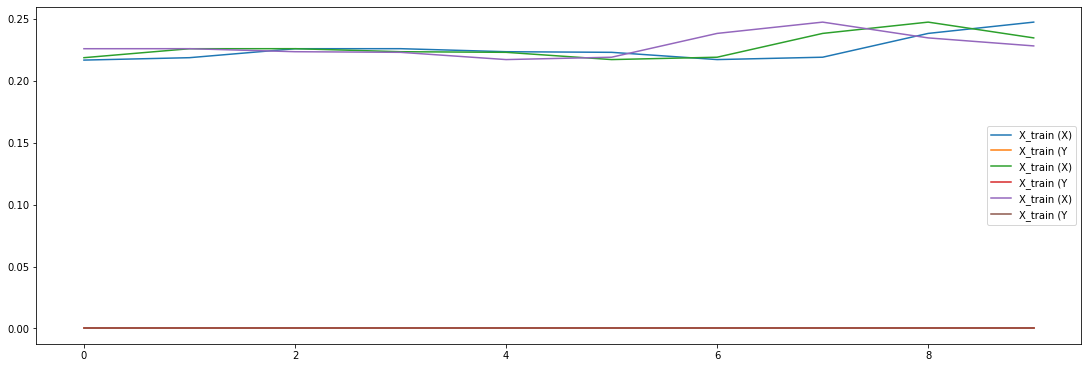

In [296]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

for i in range(0,3):
  ax.plot(np.linspace(0,longueur_sequence-1,longueur_sequence),x_train[0][i,:,0],label="X_train (X)")
  ax.plot(np.linspace(0,longueur_sequence-1,longueur_sequence-1),x_train[1][i,:,0],label="X_train (Y")

ax.legend()
plt.show()

# Création du modèle DA-RNN

**1. Création de la couche d'encodeur à base de LSTM**

In [386]:
class Encodeur(tf.keras.layers.Layer):
  def __init__(self, dim_LSTM, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_LSTM = dim_LSTM          # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_LSTM = tf.keras.layers.LSTM(self.dim_LSTM,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,recurrent_dropout=self.drop, name="LSTM_Encodeur")
    self.We = self.add_weight(shape=(input_shape[1],2*self.dim_LSTM),initializer="normal",name="We")    # (Tin, 2x#LSTM)
    self.Ue = self.add_weight(shape=(input_shape[1],input_shape[1]),initializer="normal",name="Ue")     # (Tin, Tin)
    self.be = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="be")                  # (Tin, 1)
    self.ve = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="ve")                  # (Tin, 1)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,#dim)
  #     hidd_state:     hidden_state        : (batch_size,#LSTM)
  #     cell_state:     Cell state          : (batch_size,#LSTM)]
  #     index:          index série         : (1)
  # Sorties :
  #     out_hid : Sortie vecteur caché      : (batch_size,#LSTM)
  #     out_cell: Sortie cell state         : (btach_size,#LSTM)
  def call(self, input, hidd_state, cell_state, index):
    # Calcul des poids normalisés
    scores = []
    for i in range(input.shape[2]):
      if hidd_state is not None:
        hs = tf.keras.layers.concatenate([hidd_state,cell_state],axis=1)        # (batch_size,2x#LSTM)
        hs = tf.expand_dims(hs,-1)                                              # (batch_size,2x#LSTM) => (batch_size,2#LSTM,1)
        e = tf.matmul(self.We,hs)                                               # (Tin,2x#LSTM)x(batch_size,2x#LSTM,1) = (batch_size,Tin,1)
        e = e + tf.matmul(self.Ue,tf.expand_dims(input[:,:,i],-1))              # (Tin,Tin)x(batch_size,Tin,1) = (batch_size,Tin,1)
        e = e + self.be                                                         # (batch_size,Tin,1)
      else:
        e = tf.matmul(self.Ue,tf.expand_dims(input[:,:,i],-1))                  # (Tin,Tin)x(batch_size,Tin,1) = (batch_size,Tin,1)
        e = e + self.be                                                         # (batch_size,Tin,1)
 
      e = K.tanh(e)
      scores.append(tf.matmul(tf.transpose(self.ve),e))                       # (1,Tin)x(batch_size,Tin,1) = (batch_size,1,1)
    
    a = tf.convert_to_tensor(scores)                                          # (#dim,batch_size,1,1)
    a = tf.keras.activations.softmax(a,axis=0)                                # (#dim,batch_size,1,1)
    a = tf.squeeze(a,-1)                                                      # (#dim,batch_size,1)
    a = tf.transpose(a,perm=[1,0,2])                                          # (batch_size,#dim,1)

    # Applique les poids normalisés à la série
    x_tilda = tf.multiply(tf.expand_dims(input[:,index,:],-1),a)              # (batch_size,#dim,1) _x_ (batch_size,#dim,1) = (batch_size,#dim,1)
    x_tilda = tf.transpose(x_tilda,perm=[0,2,1])                              # (batch_size,1,#dim)

    # Applique x_tilda à la cellule LSTM
    out_dec, out_hid, out_cell = self.couche_LSTM(x_tilda)                    # out_dec et out_cell : (batch_size,#LSTM)

    return out_hid, out_cell


In [325]:
out, hid, cell = tf.keras.layers.LSTM(units=128,return_sequences=False,return_state=True)(tf.expand_dims(x_train[0][:,:,0],1))

In [ ]:
tf.keras.layers.concatenate([hid,cell],axis=1)

In [313]:
hid.shape

TensorShape([22016, 128])

In [ ]:
Encodeur(dim_LSTM=128)(x_train[0],hid,cell,0)

In [333]:
x_train[0].shape

(22016, 10, 3)

In [358]:
x_train[0][:,0,:].shape

(22016, 3)

**2. Création de la couche de décodeur**

In [387]:
class Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_LSTM, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_LSTM = dim_LSTM            # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_LSTM = tf.keras.layers.LSTM(self.dim_LSTM,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,recurrent_dropout=self.drop, name="LSTM_Decodeur")
    self.couche_Dense = tf.keras.layers.Dense(units=1,kernel_regularizer=tf.keras.regularizers.l2(self.regul))
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée décodeur       : (batch_size,1,1) 
  #     hidden:   Vecteur caché         : (batch_size,1,128)
  # Sorties :
  #     out_dec : Sortie décodeur       : (batch_size,1,1)
  #     out_hid : Sortie vecteur caché  : (batch_size,1,128)
  def call(self,input,hidden):
    out_dec, out_hid, state_c = self.couche_LSTM(input,initial_state=hidden)
    out_dec = self.couche_Dense(out_dec)
    return out_dec, out_hid

**3. Création de la couche réseau**

In [388]:
class Net_DARNN(tf.keras.layers.Layer):
  def __init__(self,encodeur,decodeur,longueur_sequence, dim_LSTM, regul=0.0, drop = 0.0):
    self.encodeur = encodeur
    self.decodeur = decodeur
    self.longueur_sequence = longueur_sequence
    self.regul = regul
    self.drop = drop
    self.dim_LSTM = dim_LSTM
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,#dim)
  #     output_seq:     Sortie séquence Y   : (batch_size,Tin-1,1)
  # Sorties :
  #     sortie:         Prédiction Y        : (batch_size,1,1)
  def call(self,input,output_seq):
    # Calcul de l'attention spatiale
    hid = []
    hid_state = None
    cell_state = None
    for i in range(input.shape[1]):
      hid_state, cell_state = self.encodeur(input,hid_state,cell_state,i)
      hid.append(hid_state)
    
    hid = tf.convert_to_tensor(hid)               # (Tin,batch_size,#LSTM)
    print(hid.shape)

    return sortie

In [389]:
dim_LSTM = 128
drop=0.01
l2reg=0.001

encodeur = Encodeur(dim_LSTM=dim_LSTM,drop=drop,regul=l2reg)
decodeur = Decodeur(dim_LSTM=dim_LSTM,drop=drop,regul=l2reg)

Net_DARNN(encodeur,decodeur,longueur_sequence=longueur_sequence,dim_LSTM=dim_LSTM)(x_train[0],x_train[1])

(10, 22016, 128)


NameError: ignored

**4. Création du modèle**

In [ ]:
dim_LSTM = 128
drop=0.01
l2reg=0.001

def get_model():
  entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,1))
  sorties_sequences = tf.keras.layers.Input(shape=(longueur_sortie,1))

  encodeur = Encodeur(dim_LSTM=dim_LSTM,drop=drop,regul=l2reg)
  decodeur = Decodeur(dim_LSTM=dim_LSTM,drop=drop,regul=l2reg)

  sortie = Net_GRU(encodeur,decodeur,longueur_sequence=longueur_sequence, longueur_sortie=longueur_sortie)(entrees_sequences,sorties_sequences)

  model = CustomModel([entrees_sequences,sorties_sequences],sortie)
  return model

# Entrainement avec TPU

In [ ]:
from google.colab import files

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  # Création du modèle
  model = CustomModel()

  # Définition des paramètres liés à l'évolution du taux d'apprentissage
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.001,
      decay_steps=50,
      decay_rate=0.07)

  optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

  # Entraine le modèle
  historique = model.fit(x=[x_train,y_train],y=y_train,validation_data=([x_val,y_val],y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)],batch_size=batch_size)

files.download('poids_train.hdf5')

In [ ]:
model.load_weights("poids_train.hdf5")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
model.evaluate(x=[x_train,y_train],y=y_train)
model.evaluate(x=[x_val,y_val],y=y_val)

# Chargement du modèle pré-entrainé

**Seq2Seq_Multi_LSTMBiDir128_DR01_L2_001_BS128_EP1000_5J_12H :**  

*   Élément de liste
*   Élément de liste


	- Encodeur Bidirectionnel LSTM #128  
	- Longueur entrée : 5 jours  
	- Longueur sortie : 12h  
	- Drop : 0.2  
	- L2 : 0.01  
	- Batch Size : 128  
	- Périodes : 1000  
	=> mse :  6.75e-4 / 0.0116
  
  <img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2Seq/images/Seq2Seq_Multi_LSTMBiDir128_DR01_L2_001_BS128_EP1000_5J_12H.png?raw=true' width=500/>

In [ ]:
model = get_model()

In [ ]:
!rm *.hdf5
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Seq2Seq/Modeles/Seq2Seq_Multi_LSTMBiDir128_DR01_L2_001_BS128_EP1000_5J_12H.hdf5"

In [ ]:
model.load_weights("Seq2Seq_Multi_LSTMBiDir128_DR01_L2_001_BS128_EP1000_5J_12H.hdf5")

# Prédictions multi-step

In [ ]:
pred_ent = model.predict([x_train,y_train],verbose=1)
pred_val = model.predict([x_val,y_val],verbose=1)

In [ ]:
import plotly.graph_objects as go

decalage = longueur_sortie

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=serie_entrainement_X_norm[:,-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,-1],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []
pred_index = []
step_time = []
step_val = []

max = int(len(pred_ent)/longueur_sortie)
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i*longueur_sortie,0:decalage,:],1))
  pred_index.append(df_etude.index[longueur_sequence+i*longueur_sortie:longueur_sequence+(i+1)*longueur_sortie])
  step_val.append(pred_ent[i*longueur_sortie,0,0])
  step_time.append(df_etude.index[longueur_sequence+i*longueur_sortie])

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

pred_index = np.asarray(pred_index)
pred_index = np.reshape(pred_index,(pred_index.shape[0]*pred_index.shape[1]))

fig.add_trace(go.Scatter(x=pd.to_datetime(pred_index),y=pred, mode='lines', line=dict(color='green', width=1)))
fig.add_trace(go.Scatter(x=step_time,y=step_val, mode='markers', line=dict(color='black', width=1)))


#Affiche les prédictions sur les validations
pred = []
pred_index = []
step_time = []
step_val = []
max = int(len(pred_val)/longueur_sortie)
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i*longueur_sortie,0:decalage,:],1))
  pred_index.append(df_etude.index[temps_separation+i*decalage+longueur_sequence:temps_separation+i*decalage+longueur_sequence+longueur_sortie])
  step_val.append(pred_val[i*longueur_sortie,0,0])
  step_time.append(df_etude.index[temps_separation+i*decalage+longueur_sequence])

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))
pred_index = np.asarray(pred_index)
pred_index = np.reshape(pred_index,(pred_index.shape[0]*pred_index.shape[1]))

fig.add_trace(go.Scatter(x=pd.to_datetime(pred_index),y=pred, mode='lines', line=dict(color='green', width=1)))
fig.add_trace(go.Scatter(x=step_time,y=step_val, mode='markers', line=dict(color='black', width=1)))



fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Prédictions single-step

In [ ]:
import plotly.graph_objects as go

decalage = 1

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=serie_entrainement_X_norm[:,-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,-1],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

#Affiche les prédictions sur les validations
pred = []
max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()